In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
record_path = "C:\\Users\\Lenovo\\Desktop\\ECG\\data\\mit-bih-normal-sinus-rhythm-database-1.0.0\\16265"

In [3]:
record = wfdb.rdrecord(record_path)
ann = wfdb.rdann(record_path, 'atr')

In [4]:
signal = record.p_signal[:, 0]  # First lead

# Define sampling frequency and segment duration
fs = record.fs  # Sampling frequency (in Hz)
segment_duration = 5 * 60  # 5 minutes in seconds
samples_per_segment = fs * segment_duration

# Split the ECG into 5-minute segments
segments = [signal[i:i + samples_per_segment] for i in range(0, len(signal), samples_per_segment)]

In [5]:
# Apply Discrete Wavelet Transform (DWT) for denoising
def denoise_signal(signal, wavelet='sym5', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, np.std(c) * 0.5, mode='soft') for c in coeffs[1:]]  # Denoising
    return pywt.waverec(coeffs, wavelet)


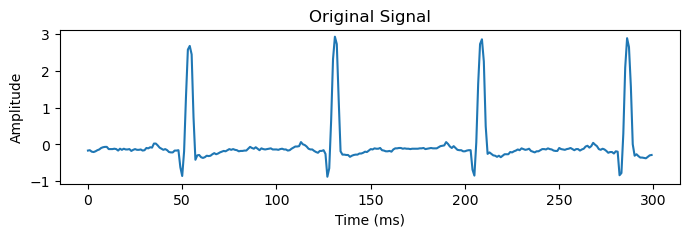

In [35]:
plt.figure(figsize=(8, 2))
plt.plot(segments[0][:300])
plt.title('Original Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

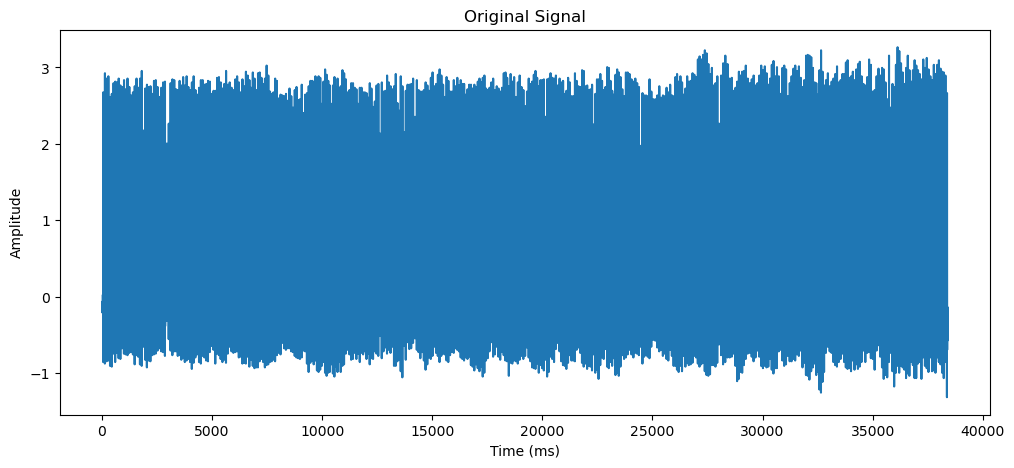

In [8]:
import pywt
# Denoise each segment
denoised_segments = [denoise_signal(seg) for seg in segments]

# Plot original and denoised signal
plt.figure(figsize=(12, 5))
plt.plot(segments[0])
plt.title('Original Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

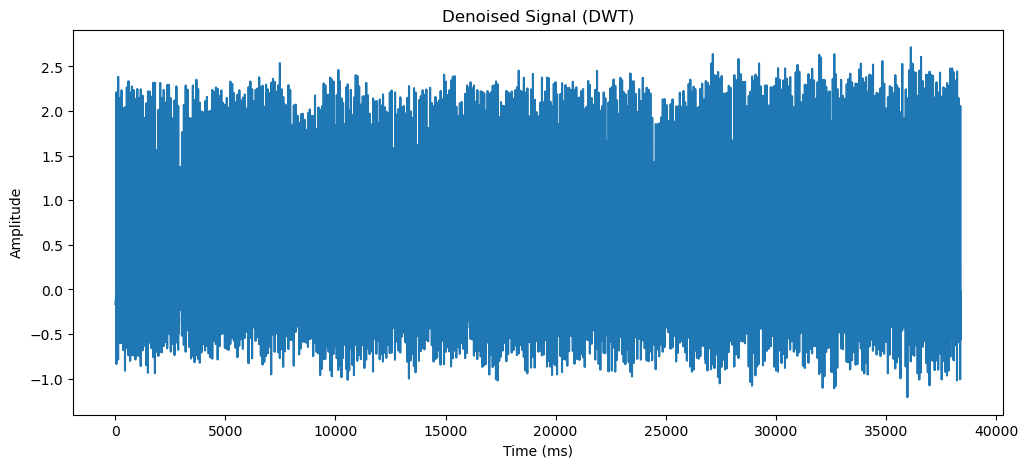

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(denoised_segments[0])
plt.title('Denoised Signal (DWT)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()


In [11]:
# Normalization Functions
def nadev(signal):
    median_x = np.median(signal)
    mad = np.median(np.abs(signal - median_x))
    return (signal - median_x) / mad if mad != 0 else signal

def nadiff(signal):
    diff = np.diff(signal, prepend=signal[0])  # First-order difference
    return diff / (np.max(signal) - np.min(signal)) if np.max(signal) != np.min(signal) else signal

Text(0, 0.5, 'Amplitude')

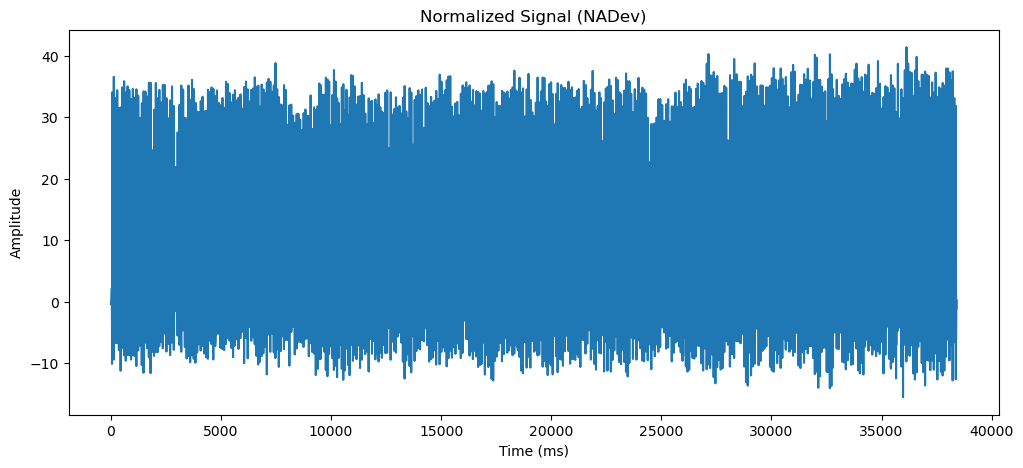

In [13]:
# Apply Normalization to Denoised Segments
nadev_segments = [nadev(seg) for seg in denoised_segments]
nadiff_segments = [nadiff(seg) for seg in denoised_segments]

# Plot Normalized Signals
plt.figure(figsize=(12, 5))
plt.plot(nadev_segments[0])
plt.title('Normalized Signal (NADev)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

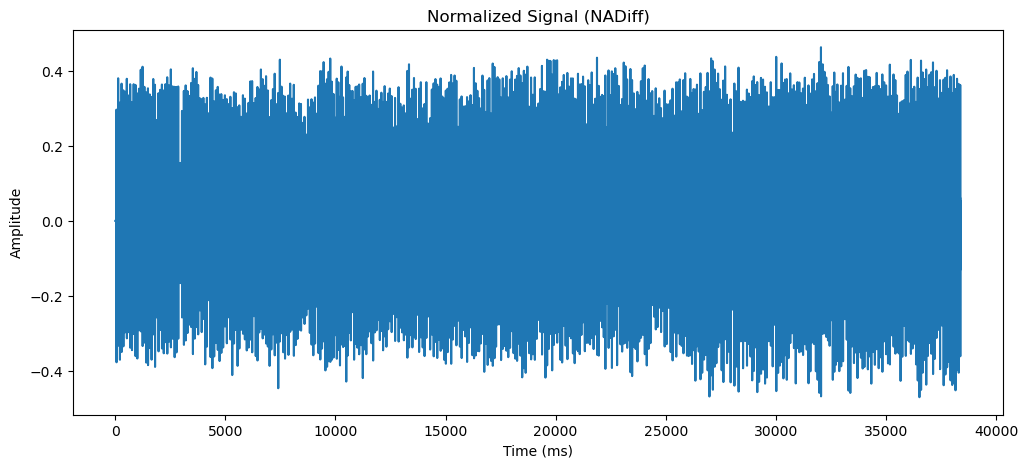

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(nadiff_segments[0])
plt.title('Normalized Signal (NADiff)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

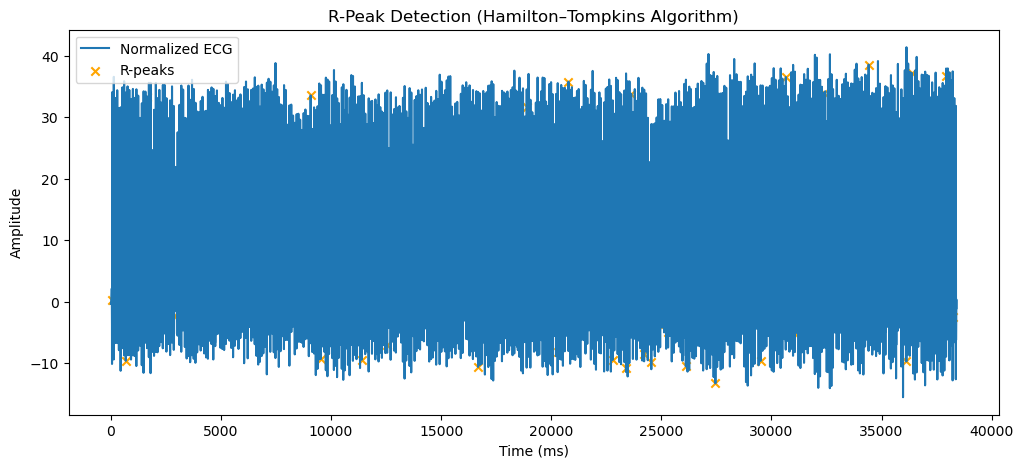

In [16]:
from scipy.signal import find_peaks, butter, filtfilt

# Bandpass filter to remove baseline wander and high-frequency noise
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=360, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Detect R-peaks using thresholding and peak detection
def detect_r_peaks(signal, fs=360):
    filtered_signal = bandpass_filter(signal, 0.5, 50, fs)

    # Differentiation to highlight slopes
    diff_signal = np.diff(filtered_signal, prepend=filtered_signal[0])

    # Squaring to emphasize peaks
    squared_signal = diff_signal ** 2

    # Moving window integration (window ~150ms)
    window_size = int(0.15 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode='same')

    # Detect peaks
    peaks, _ = find_peaks(integrated_signal, height=np.mean(integrated_signal) * 1.2, distance=fs//2)
    return peaks

# Apply R-peak detection to a normalized segment
r_peaks = detect_r_peaks(nadev_segments[0])

# Plot the R-peaks on the ECG signal
plt.figure(figsize=(12, 5))
plt.plot(nadev_segments[0], label='Normalized ECG')
plt.scatter(r_peaks, nadev_segments[0][r_peaks], color='orange', marker='x', label='R-peaks')
plt.title('R-Peak Detection (Hamilton–Tompkins Algorithm)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

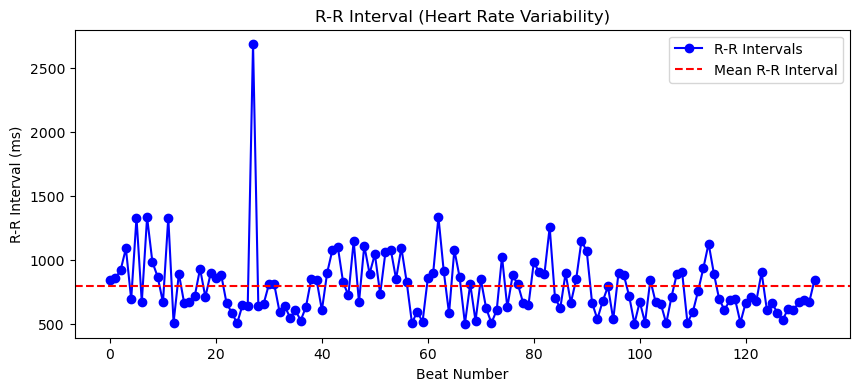

In [17]:
# Compute R-R Intervals (in milliseconds)
def compute_rr_intervals(r_peaks, fs=360):
    rr_intervals = np.diff(r_peaks) * (1000 / fs)  # Convert to milliseconds
    return rr_intervals

# Apply RR interval calculation
rr_intervals = compute_rr_intervals(r_peaks)

# Plot RR Intervals
plt.figure(figsize=(10, 4))
plt.plot(rr_intervals, marker='o', linestyle='-', color='b', label='R-R Intervals')
plt.axhline(np.mean(rr_intervals), color='r', linestyle='--', label='Mean R-R Interval')
plt.xlabel('Beat Number')
plt.ylabel('R-R Interval (ms)')
plt.title('R-R Interval (Heart Rate Variability)')
plt.legend()
plt.show()

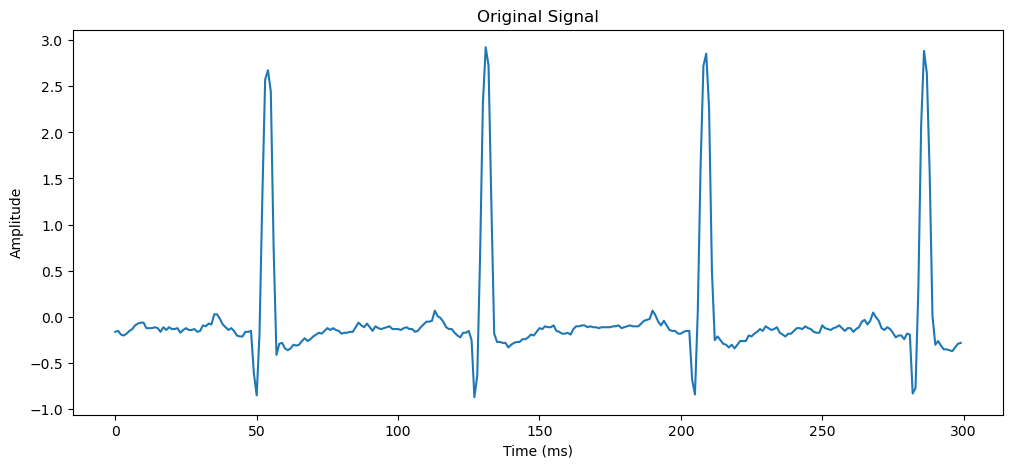

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(segments[0][:300])
plt.title('Original Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()